# DARE Deluxe Data Challenge I
DARE 2023

In this notebook, we will provide a template for the DARE Deluxe Data Challenge. The main steps covered here will be:

- Load the data
- Provide an overview of what is in the data
- Provide an example of a terribly performing baseline model
- Provide functions to quantify model predictive performance

In [1]:
colab = False
if colab:
    !git clone https://github.com/dare-centre/DDC-I
    import os
    os.chdir('DDC-I')
    !ls

In [2]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports and settings
Everything we need to get started.

In [3]:
import os, sys, copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# plotting
from functions.plotting_functions import (plot_model_fit) 
# helper
from functions.helper_functions import (assess_model_prediction, inversescaler_pred_dict)
# data
from functions.data_functions import(load_daily_data) 

## Load the data


In [4]:
train_val_x, train_val_y, test_x_all, test_y = load_daily_data()

y_var = 'v2_WE 16-03 B3' # Gauge name to predict
train_val_y = train_val_y[y_var].to_frame()
test_y = test_y[y_var].to_frame()

train_val_x.head()

,evap_narrabri,evap_narrabri_lag1,evap_narrabri_lag2,evap_narrabri_lag3,evap_turrawan,evap_turrawan_lag1,evap_turrawan_lag2,evap_turrawan_lag3,mlsp_wheat,mlsp_wheat_lag1,...,winddir_wheat_lag2,winddir_wheat_lag3,windspeed_mulgate,windspeed_mulgate_lag1,windspeed_mulgate_lag2,windspeed_mulgate_lag3,windspeed_wheat,windspeed_wheat_lag1,windspeed_wheat_lag2,windspeed_wheat_lag3
2022-01-01,6.5,6.8,6.4,4.7,6.5,6.7,6.1,4.5,1011.947474,1013.230645,...,135.410526,140.273684,8.784375,7.819792,10.697917,14.258333,9.548421,7.380645,9.246316,14.586316
2022-01-02,5.9,6.5,6.8,6.4,5.7,6.5,6.7,6.1,1011.008298,1011.947474,...,130.580645,135.410526,5.294792,8.784375,7.819792,10.697917,5.592553,9.548421,7.380645,9.246316
2022-01-03,7.7,5.9,6.5,6.8,7.5,5.7,6.5,6.7,1007.383441,1011.008298,...,112.052632,130.580645,7.663542,5.294792,8.784375,7.819792,7.572043,5.592553,9.548421,7.380645
2022-01-04,7.5,7.7,5.9,6.5,7.3,7.5,5.7,6.5,1006.500412,1007.383441,...,160.446809,112.052632,18.892708,7.663542,5.294792,8.784375,18.122680,7.572043,5.592553,9.548421
2022-01-05,8.3,7.5,7.7,5.9,7.9,7.3,7.5,5.7,1006.508660,1006.500412,...,149.537634,160.446809,20.490625,18.892708,7.663542,5.294792,20.786598,18.122680,7.572043,5.592553


In [5]:
# lets look at some properties of the data 
print('Number of features: {}'.format(train_val_x.shape[1]))
print('Number of training observations: {}'.format(train_val_x.shape[0]))
print('Number of test observations: {}'.format(test_x_all.shape[0]))
print('''
Feature short names (daily average or cumulative daily for rainfall):\n
- evap_: Evaporation at various stations
- rain_: Rainfall at various stations
- temp_: Temperature at various stations (including max/min daily)
- relhumidity_: Relative humidity at various stations
- solarrad_: Solar radiation at various stations
- mlsp_: Mean sea level pressure at various stations
- uv_: UV index at various stations
- windspeed_: Wind speed at various stations
- winddir_: Wind direction at various stations
- {}: The name of the soil moisture gauge to predict
- _lag1: Varibale lagged by 1 day (lag2 = 2 days etc.)
'''.format(y_var))
feat_names = np.array(test_x_all.columns.tolist())
feat_names = np.insert(feat_names, np.arange(5,feat_names.__len__(),5), '\n')
print('Feature names:\n | {} |'.format(' | '.join(feat_names)))
print('Predict variable: {}'.format(train_val_y.columns.tolist()))

Number of features: 89
Number of training observations: 273
Number of test observations: 182

Feature short names (daily average or cumulative daily for rainfall):

- evap_: Evaporation at various stations
- rain_: Rainfall at various stations
- temp_: Temperature at various stations (including max/min daily)
- relhumidity_: Relative humidity at various stations
- solarrad_: Solar radiation at various stations
- mlsp_: Mean sea level pressure at various stations
- uv_: UV index at various stations
- windspeed_: Wind speed at various stations
- winddir_: Wind direction at various stations
- v2_WE 16-03 B3: The name of the soil moisture gauge to predict
- _lag1: Varibale lagged by 1 day (lag2 = 2 days etc.)

Feature names:
 | evap_narrabri | evap_narrabri_lag1 | evap_narrabri_lag2 | evap_narrabri_lag3 | evap_turrawan | 
 | evap_turrawan_lag1 | evap_turrawan_lag2 | evap_turrawan_lag3 | mlsp_wheat | mlsp_wheat_lag1 | 
 | mlsp_wheat_lag2 | mlsp_wheat_lag3 | rain_mulgate | rain_mulgate_lag1 

## Split our training data into training and validation sets
We can either split this randomly if we are just modelling as a plain regression problem (set `shuffle = True`), or we can split it sequentially if we are modelling as a time series problem (set `shuffle = False`).


In [6]:
# randomly or sequentially split the data into training and validation sets
val_split = True # there is no benefit to using a validation in our simple linear model
shuffle = False

if val_split:
    train_x_all, val_x_all, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.2, shuffle=shuffle)
else:
    train_x_all = train_val_x
    train_y = train_val_y
    val_x_all = None
    val_y = None

# create placeholders for our model predictions
train_y_pred = None
val_y_pred = None
test_y_pred = None


## Select predictors
We will use the very simplistic approach of just assessing the correlation to the target variable and selecting the most useful features.

In [7]:
top_n = 5 # select the top n features - use None for all features
# Or specify a list of your variables names to use as predictors - use None for all features
top_variables = None

if not top_variables is None:
    top_n_features = top_variables
elif not top_n is None:
    ## YOUR CODE HERE
    # you can use your own code here to find the optimal features (say a RF)

    # example with simpler correlation approach
    # select the top n features
    corr_df = pd.concat([train_x_all, train_val_y], axis=1).corr().abs()
    # drop the observed variable
    corr_df = corr_df.drop(y_var,axis=0)
    # print the top n predictors
    print(corr_df.sort_values(by=y_var,ascending=False)[y_var].head(top_n))
    top_n_features = corr_df.sort_values(by=y_var,ascending=False).head(top_n).index.tolist()
    ## END CODE
else:
    # use all features
    top_n_features = train_x_all.columns.tolist()

# Now 
train_x = train_x_all[top_n_features]
train_time = train_x_all.index
test_x = test_x_all[top_n_features]
test_time = test_x_all.index
if val_split:
    val_x = val_x_all[top_n_features]
    val_time = val_x_all.index
else:
    val_x = None
    val_time = None


v2_WE 16-03 B3_lag1         0.929094
relhumidity_mulgate_lag1    0.486462
relhumidity_mulgate_lag2    0.482391
relhumidity_wheat_lag1      0.469184
relhumidity_wheat_lag2      0.462506
Name: v2_WE 16-03 B3, dtype: float64


## Scale the data if needed

In [8]:
use_scaler = True

if use_scaler:
    # standardise the data for better performance
    scaler_x = StandardScaler()
    train_x = scaler_x.fit_transform(train_x)
    test_x = scaler_x.transform(test_x)
    if val_split:
        val_x = scaler_x.transform(val_x)

    scaler_y = MinMaxScaler()
    train_y = scaler_y.fit_transform(train_y)
    test_y = scaler_y.transform(test_y)
    if val_split:
        val_y = scaler_y.transform(val_y)

else:
    scaler_x = None
    scaler_y = None
    # easier if they're all numpy arrays from this point in
    train_x = train_x.values
    test_x = test_x.values
    if val_split:
        val_x = val_x.values
    train_y = train_y.values
    test_y = test_y.values
    if val_split:
        val_y = val_y.values

## Train a model
We will use a simple linear regression model as a baseline. You can implement your own model here.

In [9]:
import sklearn.linear_model as lm
from sklearn.neural_network import MLPRegressor

In [10]:
## YOUR CODE HERE

# fit a linear model to the data
model = lm.LinearRegression()
model.fit(train_x,train_y)

# # fit a neural network to the data
# model = MLPRegressor(
#     hidden_layer_sizes=(100,20), max_iter=1000,
#     activation='relu', solver='adam',
# )
# model.fit(train_x,train_y.squeeze())

# predict on data
train_y_pred = model.predict(train_x)
test_y_pred = model.predict(test_x)
if not val_x is None:
    val_y_pred = model.predict(val_x)

## END CODE

## Assess model performance

When calling the `assess_model_prediction`, we will leave `test=False` so that the test data are unseen (honesty system!) until the end of the data challenge. This is to ensure that we don't just overfit the model to the test data. When making your final model run, please set `test=True` to get a final assessment of your model performance. 

In [11]:
# construct the dict of data for plotting and metrics
data_dict = {
    'train_time': train_time,
    'train_y': train_y,
    'train_y_pred': train_y_pred,
    'test_time': test_time,
    'test_y': test_y,
    'test_y_pred': test_y_pred,
    'val_time': val_time,
    'val_y': val_y,
    'val_y_pred': val_y_pred,
}
data_dict = copy.deepcopy(data_dict)
predicted_data  = inversescaler_pred_dict(data_dict, scaler=scaler_y)

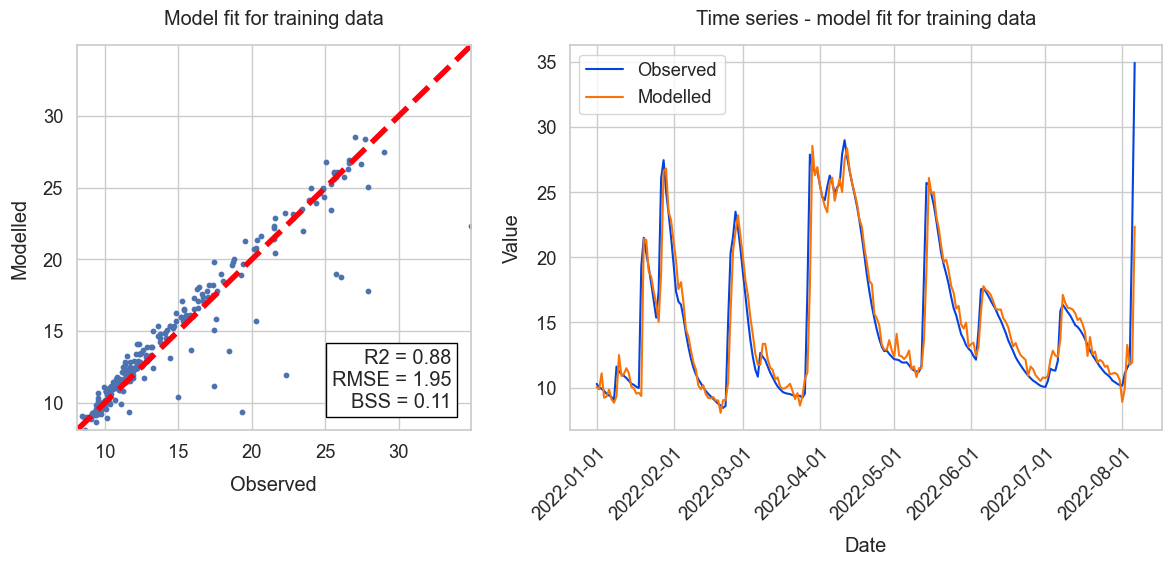

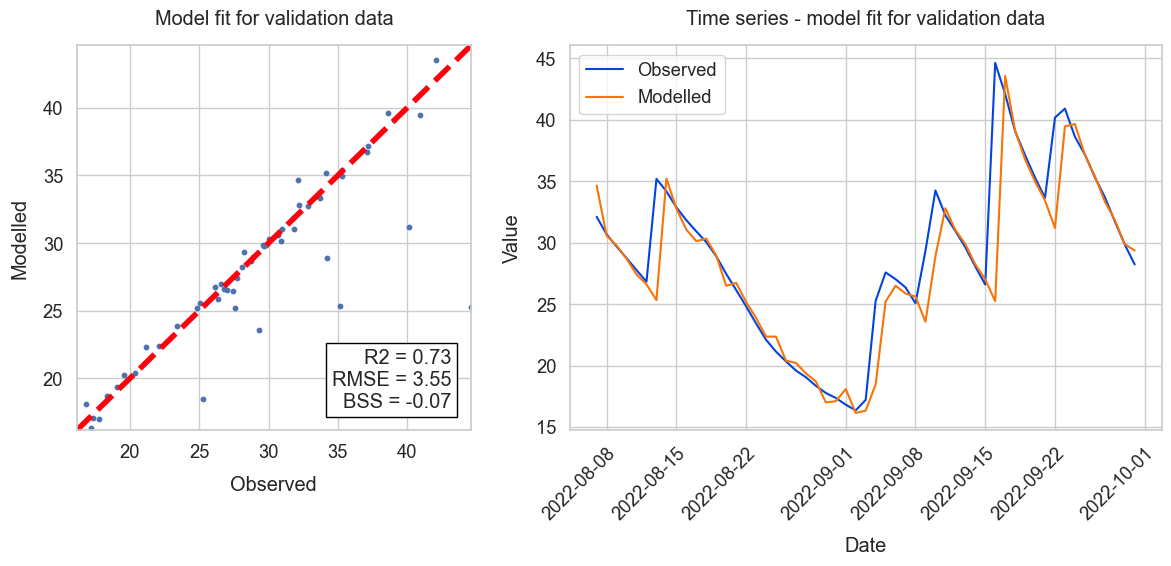

Model performance metrics:


,Train,Validation,Test
BSS,0.108,-0.071,None
R2,0.876,0.734,None
RMSE,1.952,3.547,None
MAE,1.015,1.511,None


In [12]:
# plot the model performance and get metrics
metrics = assess_model_prediction(predicted_data,test=False)
print('Model performance metrics:')
pd.set_option('display.precision', 3)
metrics